<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Segmentation_using_BASNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Highly accurate boundaries segmentation using BASNet***

# **Introduction**


Deep semantic segmentation algorithms have improved a lot recently, but still fails to correctly predict pixels around object boundaries. In this example we implement Boundary-Aware Segmentation Network (BASNet), using two stage predict and refine architecture, and a hybrid loss it can predict highly accurate boundaries and fine structures for image segmentation.


References:


Boundary-Aware Segmentation Network for Mobile and Web ApplicationsBASNet Keras ImplementationLearning to Detect Salient Objects with Image-level Supervision

In [1]:
!wget http://saliencydetection.net/duts/download/DUTS-TE.zip
!unzip -q DUTS-TE.zip

--2023-11-02 04:59:38--  http://saliencydetection.net/duts/download/DUTS-TE.zip
Resolving saliencydetection.net (saliencydetection.net)... 36.55.239.177
Connecting to saliencydetection.net (saliencydetection.net)|36.55.239.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139799089 (133M) [application/zip]
Saving to: ‘DUTS-TE.zip’

DUTS-TE.zip         100%[===================>] 133.32M  4.22MB/s    in 32s     

2023-11-02 05:00:10 (4.18 MB/s) - ‘DUTS-TE.zip’ saved [139799089/139799089]



In [2]:
pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 37.9 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend

Using TensorFlow backend


In [4]:
img_size = 288
batch_size = 4
out_classes = 1
train_split_ratio = 0.90
DATA_DIR = "/content/DUTS-TE/"

***Create TensorFlow Dataset***
We will use load_paths() to load and split 140 paths into train and validation set, and load_dataset() to convert paths into tf.data.Dataset object.

In [5]:
def load_paths(path, split_ratio):
    images = sorted(glob(os.path.join(path, "DUTS-TE-Image/*")))[:140]
    masks = sorted(glob(os.path.join(path, "DUTS-TE-Mask/*")))[:140]
    len_ = int(len(images) * split_ratio)
    return (images[:len_], masks[:len_]), (images[len_:], masks[len_:])


def read_image(path, size, mode):
    x = keras.utils.load_img(path, target_size=size, color_mode=mode)
    x = keras.utils.img_to_array(x)
    x = (x / 255.0).astype(np.float32)
    return x


def preprocess(x_batch, y_batch, img_size, out_classes):
    def f(_x, _y):
        _x, _y = _x.decode(), _y.decode()
        _x = read_image(_x, (img_size, img_size), mode="rgb")  # image
        _y = read_image(_y, (img_size, img_size), mode="grayscale")  # mask
        return _x, _y

    images, masks = tf.numpy_function(f, [x_batch, y_batch], [tf.float32, tf.float32])
    images.set_shape([img_size, img_size, 3])
    masks.set_shape([img_size, img_size, out_classes])
    return images, masks


def load_dataset(image_paths, mask_paths, img_size, out_classes, batch, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_paths, val_paths = load_paths(DATA_DIR, train_split_ratio)

train_dataset = load_dataset(
    train_paths[0], train_paths[1], img_size, out_classes, batch_size, shuffle=True
)
val_dataset = load_dataset(
    val_paths[0], val_paths[1], img_size, out_classes, batch_size, shuffle=False
)

In [6]:
print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))>


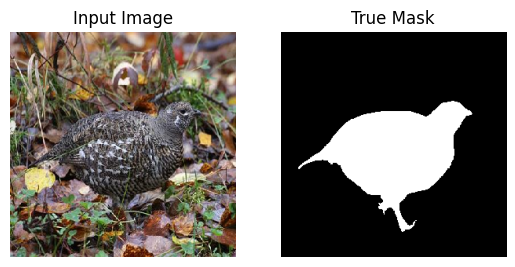

In [7]:
def display_img(display_list):
  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.imshow(keras.utils.array_to_img(display_list[i]), cmap = "gray")
    plt.title(title[i])
    plt.axis("off")
  plt.show()

for img, mask in train_dataset.take(1):
  display_img([img[0], mask[0]])

***Analyze Mask***


Lets print unique values of above displayed mask. You can see despite belonging to one class, it's intensity is changing between low(0) to high(255). This variation in intensity makes it hard for network to generate good segmentation map for salient or camouflaged object segmentation. Because of its Residual Refined Module (RMs), BASNet is good in generating highly accurate boundaries and fine structures.

In [8]:
print(f"Unique values count: {len(np.unique((mask[0] * 255)))}")
print("Unique values:")
print(np.unique((mask[0] * 255)).astype(int))

Unique values count: 2
Unique values:
[  0 255]


***Building the BASNet Model***


BASNet comprises of a predict-refine architecture and a hybrid loss. The predict-refine architecture consists of a densely supervised encoder-decoder network and a residual refinement module, which are respectively used to predict and refine a segmentation probability map.

In [9]:
def basic_block(x_input, filters, stride=1, down_sample=None, activation=None):
    """Creates a residual(identity) block with two 3*3 convolutions."""
    residual = x_input

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", use_bias=False)(
        x_input
    )
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", use_bias=False)(
        x
    )
    x = layers.BatchNormalization()(x)

    if down_sample is not None:
        residual = down_sample

    x = layers.Add()([x, residual])

    if activation is not None:
        x = layers.Activation(activation)(x)

    return x


def convolution_block(x_input, filters, dilation=1):
    """Apply convolution + batch normalization + relu layer."""
    x = layers.Conv2D(filters, (3, 3), padding="same", dilation_rate=dilation)(x_input)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)


def segmentation_head(x_input, out_classes, final_size):
    """Map each decoder stage output to model output classes."""
    x = layers.Conv2D(out_classes, kernel_size=(3, 3), padding="same")(x_input)

    if final_size is not None:
        x = layers.Resizing(final_size[0], final_size[1])(x)

    return x


def get_resnet_block(_resnet, block_num):
    """Extract and return ResNet-34 block."""
    resnet_layers = [3, 4, 6, 3]  # ResNet-34 layer sizes at different block.
    return keras.models.Model(
        inputs=_resnet.get_layer(f"v2_stack_{block_num}_block1_1_conv").input,
        outputs=_resnet.get_layer(
            f"v2_stack_{block_num}_block{resnet_layers[block_num]}_add"
        ).output,
        name=f"resnet34_block{block_num + 1}",
    )

***Prediction Module***


Prediction module is a heavy encoder decoder structure like U-Net. The encoder includes an input convolutional layer and six stages. First four are adopted from ResNet-34 and rest are basic res-blocks. Since first convolution and pooling layer of ResNet-34 is skipped so we will use get_resnet_block() to extract first four blocks. Both bridge and decoder uses three convolutional layers with side outputs. The module produces seven segmentation probability maps during training, with the last one considered the final output.

In [10]:
def basnet_predict(input_shape, out_classes):
    """BASNet Prediction Module, it outputs coarse label map."""
    filters = 64
    num_stages = 6

    x_input = layers.Input(input_shape)

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    resnet = keras_cv.models.ResNet34Backbone(
        include_rescaling=False,
    )

    encoder_blocks = []
    for i in range(num_stages):
        if i < 4:  # First four stages are adopted from ResNet-34 blocks.
            x = get_resnet_block(resnet, i)(x)
            encoder_blocks.append(x)
            x = layers.Activation("relu")(x)
        else:  # Last 2 stages consist of three basic resnet blocks.
            x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            encoder_blocks.append(x)

    # -------------Bridge-------------
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    encoder_blocks.append(x)

    # -------------Decoder-------------
    decoder_blocks = []
    for i in reversed(range(num_stages)):
        if i != (num_stages - 1):  # Except first, scale other decoder stages.
            shape = keras.backend.int_shape(x)
            x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)

        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        decoder_blocks.append(x)

    decoder_blocks.reverse()  # Change order from last to first decoder stage.
    decoder_blocks.append(encoder_blocks[-1])  # Copy bridge to decoder.

    # -------------Side Outputs--------------
    decoder_blocks = [
        segmentation_head(decoder_block, out_classes, input_shape[:2])
        for decoder_block in decoder_blocks
    ]

    return keras.models.Model(inputs=[x_input], outputs=decoder_blocks)

***Residual Refinement Module***


Refinement Modules (RMs), designed as a residual block aim to refines the coarse(blurry and noisy boundaries) segmentation maps generated by prediction module. Similar to prediction module it's also an encode decoder structure but with light weight 4 stages, each containing one convolutional block() init. At the end it adds both coarse and residual output to generate refined output.

In [11]:
def basnet_rrm(base_model, out_classes):
    """BASNet Residual Refinement Module(RRM) module, output fine label map."""
    num_stages = 4
    filters = 64

    x_input = base_model.output[0]

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    encoder_blocks = []
    for _ in range(num_stages):
        x = convolution_block(x, filters=filters)
        encoder_blocks.append(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # -------------Bridge--------------
    x = convolution_block(x, filters=filters)

    # -------------Decoder--------------
    for i in reversed(range(num_stages)):
        shape = keras.backend.int_shape(x)
        x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)
        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters)

    x = segmentation_head(x, out_classes, None)  # Segmentation head.

    # ------------- refined = coarse + residual
    x = layers.Add()([x_input, x])  # Add prediction + refinement output

    return keras.models.Model(inputs=[base_model.input], outputs=[x])

***Combine Predict and Refinement Module***

In [12]:
def basnet(input_shape, out_classes):
    """BASNet, it's a combination of two modules
    Prediction Module and Residual Refinement Module(RRM)."""

    # Prediction model.
    predict_model = basnet_predict(input_shape, out_classes)
    # Refinement model.
    refine_model = basnet_rrm(predict_model, out_classes)

    output = [refine_model.output]  # Combine outputs.
    output.extend(predict_model.output)

    output = [layers.Activation("sigmoid")(_) for _ in output]  # Activations.

    return keras.models.Model(inputs=[predict_model.input], outputs=output)

**Hybrid Loss**


Another important feature of BASNet is its hybrid loss function, which is a combination of binary cross entropy, structural similarity and intersection-over-union losses, which guide the network to learn three-level (i.e., pixel, patch and map level) hierarchy representations.

In [13]:
class BasnetLoss(keras.losses.Loss):
    """BASNet hybrid loss."""

    def __init__(self, **kwargs):
        super().__init__(name="basnet_loss", **kwargs)
        self.smooth = 1.0e-9

        # Binary Cross Entropy loss.
        self.cross_entropy_loss = keras.losses.BinaryCrossentropy()
        # Structural Similarity Index value.
        self.ssim_value = tf.image.ssim
        #  Jaccard / IoU loss.
        self.iou_value = self.calculate_iou

    def calculate_iou(
        self,
        y_true,
        y_pred,
    ):
        """Calculate intersection over union (IoU) between images."""
        intersection = backend.sum(backend.abs(y_true * y_pred), axis=[1, 2, 3])
        union = backend.sum(y_true, [1, 2, 3]) + backend.sum(y_pred, [1, 2, 3])
        union = union - intersection
        return backend.mean(
            (intersection + self.smooth) / (union + self.smooth), axis=0
        )

    def call(self, y_true, y_pred):
        cross_entropy_loss = self.cross_entropy_loss(y_true, y_pred)

        ssim_value = self.ssim_value(y_true, y_pred, max_val=1)
        ssim_loss = backend.mean(1 - ssim_value + self.smooth, axis=0)

        iou_value = self.iou_value(y_true, y_pred)
        iou_loss = 1 - iou_value

        # Add all three losses.
        return cross_entropy_loss + ssim_loss + iou_loss


basnet_model = basnet(
    input_shape=[img_size, img_size, 3], out_classes= out_classes )  # Create model.
basnet_model.summary()  # Show model summary.

optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
# Compile model.
basnet_model.compile(
    loss=BasnetLoss(),
    optimizer=optimizer,
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 288, 288, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 288, 288, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 resnet34_block1 (Functiona  (None, None, None, 64)       222720    ['conv2d[0][0]']              
 l)                                                                                               
                                                                                                  
 activation (Activation)     (None, 288, 288, 64)         0         ['resnet34_block1[0][0]'

In [14]:
basnet_model.fit(train_dataset, validation_data=val_dataset, epochs=1)

32/32 [==============================] - 344s 7s/step - loss: 16.7317 - activation_46_loss: 2.0707 - activation_47_loss: 2.1917 - activation_48_loss: 2.1667 - activation_49_loss: 2.1746 - activation_50_loss: 2.0934 - activation_51_loss: 2.0185 - activation_52_loss: 1.9602 - activation_53_loss: 2.0560 - activation_46_mae: 0.2315 - activation_47_mae: 0.2910 - activation_48_mae: 0.2958 - activation_49_mae: 0.2960 - activation_50_mae: 0.2767 - activation_51_mae: 0.2669 - activation_52_mae: 0.2482 - activation_53_mae: 0.2583 - val_loss: 19.1406 - val_activation_46_loss: 2.5192 - val_activation_47_loss: 2.5552 - val_activation_48_loss: 2.2955 - val_activation_49_loss: 2.2387 - val_activation_50_loss: 2.4414 - val_activation_51_loss: 2.4283 - val_activation_52_loss: 2.3536 - val_activation_53_loss: 2.3086 - val_activation_46_mae: 0.4521 - val_activation_47_mae: 0.4760 - val_activation_48_mae: 0.3925 - val_activation_49_mae: 0.2658 - val_activation_50_mae: 0.2014 - val_activation_51_mae: 0.188

**Visualize Predictions**

In paper BASNet was trained on DUTS-TR dataset, which has 10553 images. Model was trained for 400k iterations with a batch size of eight and without a validation dataset. After training model was evaluated on DUTS-TE dataset and achieved a mean absolute error of 0.042.


Since BASNet is a deep model and cannot be trained in a short amount of time which is a requirement for keras example notebook, so we will load pretrained weights from here to show model prediction. Due to computer power limitation this model was trained for 120k iterations but it still demonstrates its capabilities. For further details about trainings parameters please check given link.

In [15]:
!!gdown 1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg

['Downloading...',
 'From: https://drive.google.com/uc?id=1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg',
 'To: /content/basnet_weights.h5',
 '',
 '  0% 0.00/436M [00:00<?, ?B/s]',
 '  1% 4.72M/436M [00:00<00:17, 24.3MB/s]',
 '  2% 8.91M/436M [00:00<00:17, 24.8MB/s]',
 '  4% 17.3M/436M [00:00<00:11, 37.3MB/s]',
 '  6% 25.7M/436M [00:00<00:12, 32.1MB/s]',
 '  8% 34.1M/436M [00:00<00:10, 37.0MB/s]',
 ' 10% 42.5M/436M [00:01<00:09, 42.1MB/s]',
 ' 12% 50.9M/436M [00:01<00:10, 37.5MB/s]',
 ' 14% 59.2M/436M [00:01<00:09, 38.9MB/s]',
 ' 16% 67.6M/436M [00:01<00:08, 42.1MB/s]',
 ' 17% 76.0M/436M [00:01<00:07, 47.5MB/s]',
 ' 19% 84.4M/436M [00:02<00:07, 49.6MB/s]',
 ' 21% 92.8M/436M [00:02<00:06, 49.3MB/s]',
 ' 25% 107M/436M [00:02<00:04, 68.0MB/s] ',
 ' 26% 115M/436M [00:02<00:05, 61.0MB/s]',
 ' 29% 126M/436M [00:02<00:04, 64.5MB/s]',
 ' 33% 143M/436M [00:02<00:03, 74.0MB/s]',
 ' 37% 160M/436M [00:02<00:03, 83.7MB/s]',
 ' 39% 169M/436M [00:03<00:03, 76.3MB/s]',
 ' 42% 185M/436M [00:03<00:02, 84.9MB/s]',
 

In [16]:
def normalize_output(prediction):
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    return (prediction - min_value) / (max_value - min_value)


# Load weights.
basnet_model.load_weights("./basnet_weights.h5")

1/1 [==============================] - 0s 38ms/step


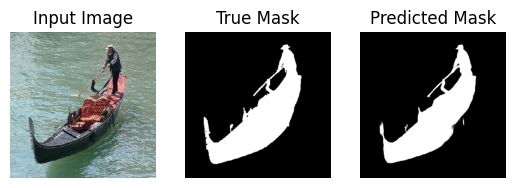

In [19]:
for image, mask in val_dataset.take(1):
    pred_mask = basnet_model.predict(image)
    display_img([image[1], mask[1], normalize_output(pred_mask[1][1])])